# End to End Image Classification Model

This notebook builds an end-to-end dog classification machine learning model using TensorFlow and TensorFlow Hub.

## 1. Problem Statement

Identifying Dog Breed

The goal is to develop a model that can identify the breed of a dog from a photograph.

## 2. Data

The data is collected from Kaggle: [Dog Breed Identification](https://www.kaggle.com/c/dog-breed-identification/data).

## 3. Model Evaluation

The model evaluation will be based on a file containing prediction probabilities for each dog breed.

## 4. Features

Some information about our dataset:
- We are dealing with unstructured data (images), so we will likely use deep learning/transfer learning techniques.
- The dataset contains over 10,000 images in the training set and over 10,000 images in the test set (these images are unlabeled as they are the ones we need to predict).

# Mounting Google Drive & Importing necessary libraries
1. Mounting google drive
2. Import libraries
3. Checking GPU
4. Init GPU
5. Wamup the GPU and CPU

## Import Libraries

In [664]:
# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf


# Check versions
print(f"TensorFlow Version: {tf.__version__}")
print(f"TensorFlow Hub Version: {hub.__version__}")

TensorFlow Version: 2.16.1
TensorFlow Hub Version: 0.16.1


## Mount Drive

In [665]:
import os

try:
    # Try importing the Google Colab specific module
    from google.colab import drive
    drive.mount('/content/drive')
    # If successful, set the folderlocation for Google Colab
    folderlocation = 'drive/MyDrive/Deep_Learning/'
    keras = tf.keras # Directly use tf.keras in Colab
except ModuleNotFoundError:
    # If the import fails, set the folderlocation for local system
    folderlocation = ''
    version_fn = getattr(tf.keras, "version", None)
    if version_fn and version_fn().startswith("3."):
        import tf_keras as keras
    else:
        keras = tf.keras

print(folderlocation)

## Checking GPU

In [666]:
print("GPU", "Available" if tf.config.list_physical_devices("GPU") else "Not Available")

GPU Not Available


## Init GPU

In [667]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print("GPU device not found. Running on CPU.")
else:
  print('Found GPU at: {}'.format(device_name))

GPU device not found. Running on CPU.


## Device warmup

In [668]:
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  # raise SystemError('GPU device not found')



This error most likely means that this notebook is not configured to use a GPU.  Change this in Notebook Settings via the command palette (cmd/ctrl-shift-P) or the Edit menu.




In [669]:
def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.753865999984555
GPU (s):
0.7495067999698222
GPU speedup over CPU: 1x


# Data Loading and Exploration
1. Loading Image Data
2. Displaying Sample Images
3. Exploring Image Metadata

## Loading & Exploring Image Data

In [670]:
# Load the dataset
df_labels = pd.read_csv(folderlocation + 'labels.csv')

In [671]:
# Display dataset statistics
print(df_labels.describe())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126


In [672]:
# Display the first few rows of the dataset
print(df_labels.head())

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [673]:
# Display the value counts of breeds
breed_counts = df_labels['breed'].value_counts()
print(breed_counts)

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: count, Length: 120, dtype: int64


In [674]:
# Getting the median of count of images by breed
df_labels["breed"].value_counts().median()

82.0

<Axes: xlabel='breed'>

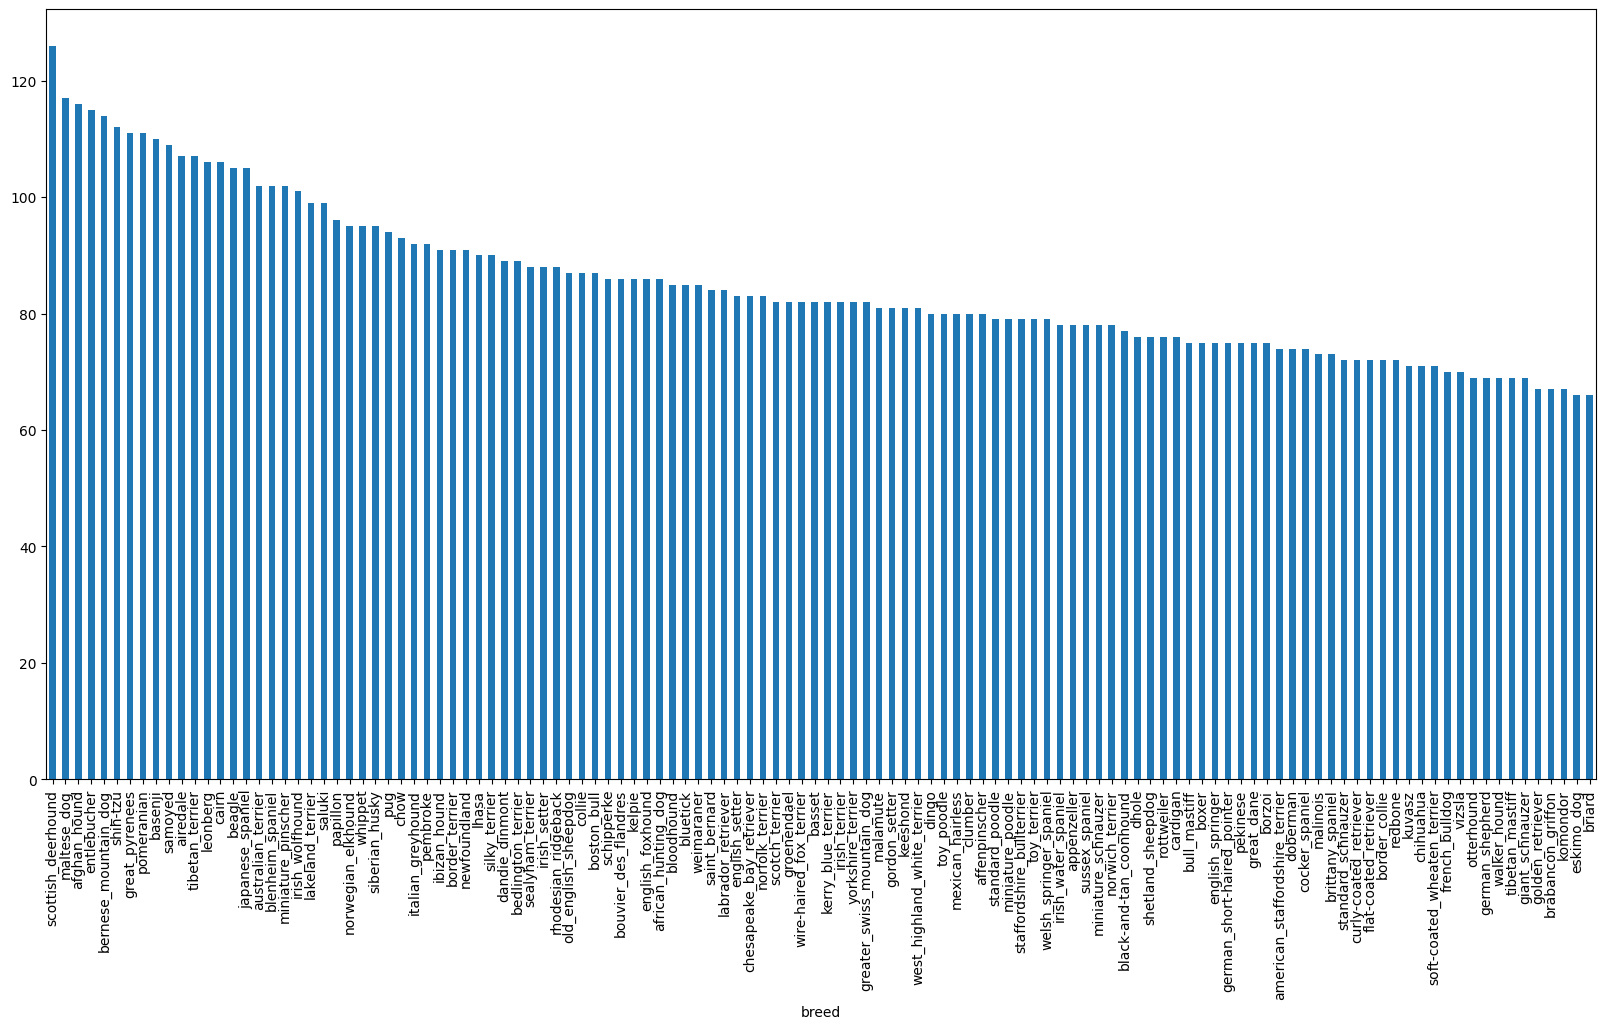

In [675]:
# Plotting grapph of count of images by breed
df_labels["breed"].value_counts().plot.bar(figsize=(20,10))

## Displaying Sample Images

In [676]:
# Displaying a sample image
from IPython.display import Image, display

# Function to display a random image
def display_random_image(df, image_folder):
    random_index = np.random.randint(len(df))
    image_id = df["id"][random_index]
    breed = df["breed"][random_index]
    image_path = f"{image_folder}/{image_id}.jpg"
    display(Image(filename=image_path))
    print(f"Image ID: {image_id}, Breed: {breed}")

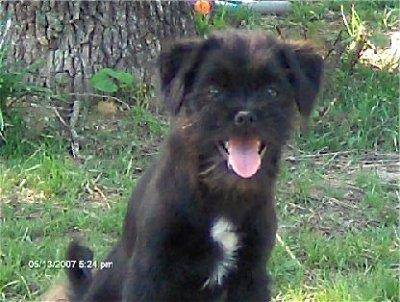

Image ID: 13ea49cd2b706ec9a15e7214e492bbb2, Breed: schipperke


In [677]:
# Display a random image from the dataset
display_random_image(df_labels, folderlocation +"train")

## Exploring Image Metadata

In [678]:
# Display specific image by index
index = 8000
image_id = df_labels["id"][index]
breed = df_labels["breed"][index]
image_path = folderlocation + f"train/{image_id}.jpg"



In [679]:
print(f"Image ID: {image_id}, Breed: {breed}")

Image ID: c81778e436da96e7a89d9ef84b367525, Breed: pomeranian


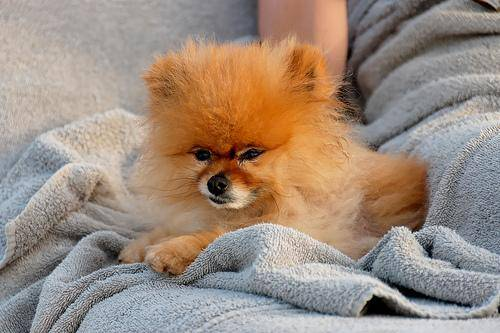

In [680]:
display(Image(filename=image_path))

# Data Preparation
1. Extracting Labels
2. Checking Data Integrity
3. Converting Labels to Boolean Values
4. Preprocessing Images
5. Creating Data Pipeline
6. Vizualizing Data Batches

## Extracting Labels

In [681]:
# Convert labels to numpy array
labels = df_labels["breed"].to_numpy()
print(labels)

['boston_bull' 'dingo' 'pekinese' ... 'airedale' 'miniature_pinscher'
 'chesapeake_bay_retriever']


## Checking Data Integrity

In [682]:
# Ensure the number of labels matches the number of filenames
if len(labels) == len(df_labels["id"]):
    print("Number of labels matches number of filenames")
else:
    print("Numbers do not match")

# Check the length of labels
print(f"Number of labels: {len(labels)}")

Number of labels matches number of filenames
Number of labels: 10222


## Converting Labels to Boolean Values

In [683]:
# Get unique breed names
unique_breeds = np.unique(labels)
print(f"Unique breeds: {unique_breeds}")

# Convert labels to boolean values
bool_labels = [label == unique_breeds for label in labels]
print(f"Boolean labels: {bool_labels[:10]}")

# Verify the length of boolean labels
print(f"Number of boolean labels: {len(bool_labels)}")

Unique breeds: ['affenpinscher' 'afghan_hound' 'african_hunting_dog' 'airedale'
 'american_staffordshire_terrier' 'appenzeller' 'australian_terrier'
 'basenji' 'basset' 'beagle' 'bedlington_terrier' 'bernese_mountain_dog'
 'black-and-tan_coonhound' 'blenheim_spaniel' 'bloodhound' 'bluetick'
 'border_collie' 'border_terrier' 'borzoi' 'boston_bull'
 'bouvier_des_flandres' 'boxer' 'brabancon_griffon' 'briard'
 'brittany_spaniel' 'bull_mastiff' 'cairn' 'cardigan'
 'chesapeake_bay_retriever' 'chihuahua' 'chow' 'clumber' 'cocker_spaniel'
 'collie' 'curly-coated_retriever' 'dandie_dinmont' 'dhole' 'dingo'
 'doberman' 'english_foxhound' 'english_setter' 'english_springer'
 'entlebucher' 'eskimo_dog' 'flat-coated_retriever' 'french_bulldog'
 'german_shepherd' 'german_short-haired_pointer' 'giant_schnauzer'
 'golden_retriever' 'gordon_setter' 'great_dane' 'great_pyrenees'
 'greater_swiss_mountain_dog' 'groenendael' 'ibizan_hound' 'irish_setter'
 'irish_terrier' 'irish_water_spaniel' 'irish_wolfh

### Cheking example boolean label and its occurence

In [684]:
print(labels[0]) #original label
print(np.where(unique_breeds==labels[0])) #index where label occured
print(bool_labels[0].argmax()) #index where label occurs in boolean array
print(bool_labels[0].astype(int)) #there will be 1 where the label occured

boston_bull
(array([19], dtype=int64),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [685]:
bool_labels[:10]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

## Preprocessing Images
1. Loading and Resizing Images
2. Normalizing Images

In [686]:
# define image size
img_size = 224

# Define function to preprocess images
def preprocess_image(image_path, img_size=img_size):
    # Read the image file
    image = tf.io.read_file(image_path)
    # Decode the image to a tensor
    image = tf.image.decode_jpeg(image, channels=3)
     #convert the color channel value form 0 - 255  to 0 - 1 values
    # image = tf.image.convert_image_dtype(image, tf.float32)
    # resizing images
    image = tf.image.resize(image, size=[img_size, img_size])
    # Normalize the image to the range [0, 1]
    image = image / 255.0
    return image

# Test the function with a sample image
sample_image_path = folderlocation + f"train/{df_labels['id'][0]}.jpg"
sample_image = preprocess_image(sample_image_path)
print(sample_image.shape)

(224, 224, 3)


## Creating Data Pipeline
1. Creating TensorFlow Dataset
2. Batching and Prefetching Data

In [687]:
batch_size = 61 #@param {type: "slider", min:61, max:1525, step:61}

In [688]:
# Function to create a TensorFlow dataset from image paths and labels
def create_data_batches(image_paths, labels, batch_size=batch_size, valid_data=False):
    if valid_data:
        print("Creating validation data batches...")
    else:
        print("Creating training data batches...")
    # Create a dataset of image paths
    dataset = tf.data.Dataset.from_tensor_slices((tf.constant(image_paths), tf.constant(labels)))
    
    # Function to load and preprocess images
    def load_and_preprocess_image(path, label):
        image = preprocess_image(path)
        return image, label
    
    # Map the load_and_preprocess_image function to the dataset
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Shuffle, batch, and prefetch the dataset
    dataset = dataset.shuffle(buffer_size=len(image_paths)).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return dataset

In [689]:
# Example image paths and labels
image_paths = [f"{folderlocation}train/{image_id}.jpg" for image_id in df_labels['id']]

### We're going start off experimenting with 3050 images and increses as needed

In [690]:

num_images = 3050 #@param {type: "slider", min:1830, max:10187, step:61}

In [691]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(image_paths[:num_images], bool_labels[:num_images], test_size = 0.2, random_state=42)
len(x_train), len(x_val), len(y_train), len(y_val)

(2440, 610, 2440, 610)

In [692]:
# Create training and validation data batches
train_data = create_data_batches(x_train, y_train)
val_data = create_data_batches(x_val, y_val, valid_data=True)

# Select one batch for visualization
one_batch_train_data = train_data.take(1)

Creating training data batches...
Creating validation data batches...


#### Visualizing Data Batches

In [693]:
import matplotlib.pyplot as plt
import math


# Function to visualize data batches
def visualize_data_batches(data_batch):
    # Iterate over the batch
    for images, labels in data_batch:
        num_images = len(images)
        # Calculate possible grid sizes
        rows = math.ceil(math.sqrt(num_images))
        cols = math.ceil(num_images / rows)
        # Plot each image in the batch
        plt.figure(figsize=(20, 10))
        for i in range(num_images):
            plt.subplot(rows, cols, i+1)
            plt.imshow(images[i])
            plt.title(unique_breeds[np.argmax(labels[i])])
            plt.axis("off")
        plt.show()


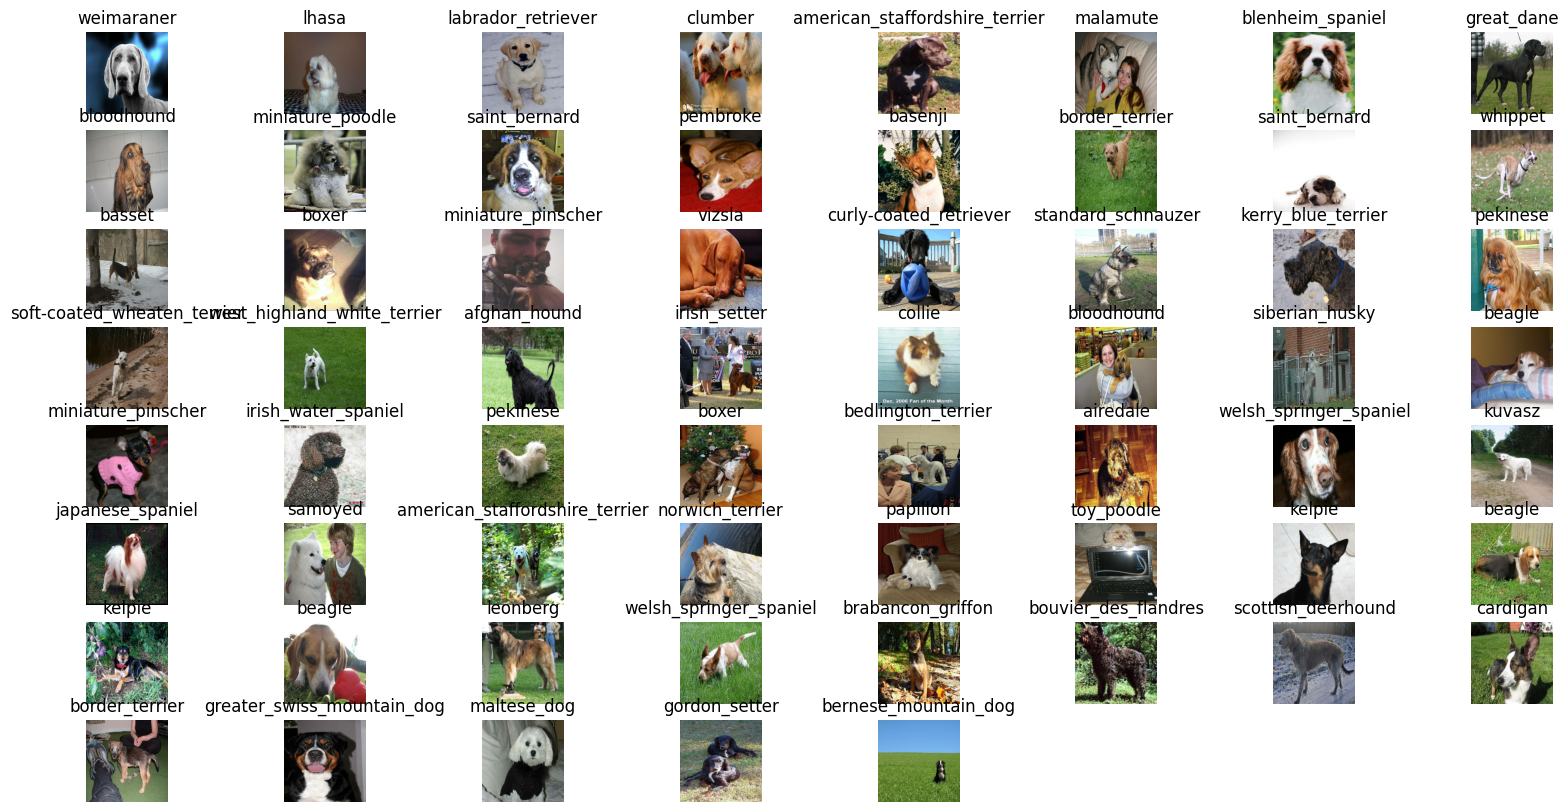

In [694]:
# Visualize one batch of training data
visualize_data_batches(one_batch_train_data)

In [695]:
print(type(val_data))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


# Model Inference and Evaluation

1. Load and Build a trained model. 
2. Creating Model Callbacks
3. Train the Model on training dataset
4. Predicting using the trained model
5. Save the model
6. Loading the trained model.
7. Evaluating the Trained Model

## Build/Create a Model

In [696]:
# setup input shape to the model
input_shape = [1, img_size, img_size, 3] # batch, height, width and color channels
output_shape = len(unique_breeds)

#setup model url from tensorflow hub (we're going to use already trained model)
model_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

In [697]:

def create_model(input_shape=input_shape, output_shape=output_shape, model_url=model_url):
    print("Building model with:", model_url)
    model = keras.Sequential([
        hub.KerasLayer(model_url, input_shape=input_shape[1:], trainable=False),  # Ensure KerasLayer is from tensorflow_hub
        keras.layers.Dense(units=output_shape, activation="softmax")
    ])
    model.compile(
        loss=keras.losses.CategoricalCrossentropy(),
        optimizer=keras.optimizers.Adam(),
        metrics=["accuracy"]
    )
    return model

In [698]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_18 (KerasLayer  (None, 1001)              3540265   
 )                                                               
                                                                 
 dense_16 (Dense)            (None, 120)               120240    
                                                                 
Total params: 3660505 (13.96 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 3540265 (13.51 MB)
_________________________________________________________________


## Creating Model Callbacks
Callbacks are essential tools that a model can use during training to perform tasks such as saving progress, monitoring performance, and stopping training if the model stops improving.

Let's create two callbacks:

1. TensorBoard Callback: This helps track the model's progress.
2. Early Stopping Callback: This stops the model training if it doesn't improve.

### TensorBoard Callback
To set up a TensorBoard Callback, we need to do the following:

1. Load the TensorBoard Notebook Extension.
2. Create a TensorBoard callback that saves the logs to a directory.
3. Visualize the model training logs using the %tensorboard magic function.

In [699]:
# Load TensorBoard notebook extension
%load_ext tensorboard

# The tensorboard extension is already loaded. To reload it, use:
# %reload_ext tensorboard

# Create a function to load a TensorBoard callback
def create_tensorboard_callback():
    logdir = os.path.join(folderlocation + "logs",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return keras.callbacks.TensorBoard(logdir)

# Example usage:
tensorboard_callback = create_tensorboard_callback()


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Early Stopping Callback
The Early Stopping Callback prevents the model from continuing training when there is no improvement.

In [700]:
# Early stopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)


In [701]:
num_epochs = 50 #@param {type:"slider", min: 10, max:100, step: 10}

In [702]:

# # Example usage:

# # Ensure these are numpy arrays
# x_train_a = np.random.rand(100, img_size, img_size, 3).astype(np.float32)  # 100 training images
# y_train_a = np.random.randint(0, output_shape, 100)
# y_train_a =keras.utils.to_categorical(y_train_a, output_shape)  # One-hot encoding

# x_val_a = np.random.rand(20, img_size, img_size, 3).astype(np.float32)  # 20 validation images
# y_val_a = np.random.randint(0, output_shape, 20)
# y_val_a = keras.utils.to_categorical(y_val_a, output_shape)  # One-hot encoding

# model.fit(x_train_a, y_train_a, 
#           validation_data=(x_val_a, y_val_a), 
#           epochs=num_epocs, 
#           callbacks=[tensorboard_callback, early_stopping])

## Model Training

In [703]:
def train_model():
    """
    Trains a model with the given training and validation data, and specified number of epochs.
    
    Args:
    train_data: Tuple of (x_train, y_train) where x_train is the training input data and y_train is the training labels.
    val_data: Tuple of (x_val, y_val) where x_val is the validation input data and y_val is the validation labels.
    num_epochs: Integer, the number of epochs to train the model.
    
    Returns:
    model: The trained TensorFlow Keras model.
    """
    # Create a new model instance
    model = create_model()

    # Setup TensorBoard callback
    tensorboard_callback = create_tensorboard_callback()

    # Fit the model
    model.fit(
        x=train_data,
        epochs=num_epochs,
        validation_data=val_data,
        validation_freq=1,
        callbacks=[tensorboard_callback, early_stopping]
    )

    return model

In [704]:
#fit the model
model = train_model()

Building model with: https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4
Epoch 1/50
40/40 [==============================] - 31s 640ms/step - loss: 3.4230 - accuracy: 0.2775 - val_loss: 1.6600 - val_accuracy: 0.5967
Epoch 2/50
40/40 [==============================] - 26s 612ms/step - loss: 0.7970 - accuracy: 0.8258 - val_loss: 1.0414 - val_accuracy: 0.7262
Epoch 3/50
40/40 [==============================] - 28s 666ms/step - loss: 0.3615 - accuracy: 0.9328 - val_loss: 0.9325 - val_accuracy: 0.7377
Epoch 4/50
40/40 [==============================] - 28s 672ms/step - loss: 0.2147 - accuracy: 0.9783 - val_loss: 0.9033 - val_accuracy: 0.7557
Epoch 5/50
40/40 [==============================] - 29s 678ms/step - loss: 0.1413 - accuracy: 0.9922 - val_loss: 0.8815 - val_accuracy: 0.7459
Epoch 6/50
40/40 [==============================] - 30s 705ms/step - loss: 0.1009 - accuracy: 0.9980 - val_loss: 0.8722 - val_accuracy: 0.7574
Epoch 7/50
40/40 [==============================] - 29

In [705]:
print(f"Number of labels: {len(labels)}, Number of filenames: {len(image_paths)}")
print(f"Unique breeds: {unique_breeds}, Number of unique breeds: {len(unique_breeds)}")
print(f"Shape of bool_labels: {np.array(bool_labels).shape}")

Number of labels: 10222, Number of filenames: 10222
Unique breeds: ['affenpinscher' 'afghan_hound' 'african_hunting_dog' 'airedale'
 'american_staffordshire_terrier' 'appenzeller' 'australian_terrier'
 'basenji' 'basset' 'beagle' 'bedlington_terrier' 'bernese_mountain_dog'
 'black-and-tan_coonhound' 'blenheim_spaniel' 'bloodhound' 'bluetick'
 'border_collie' 'border_terrier' 'borzoi' 'boston_bull'
 'bouvier_des_flandres' 'boxer' 'brabancon_griffon' 'briard'
 'brittany_spaniel' 'bull_mastiff' 'cairn' 'cardigan'
 'chesapeake_bay_retriever' 'chihuahua' 'chow' 'clumber' 'cocker_spaniel'
 'collie' 'curly-coated_retriever' 'dandie_dinmont' 'dhole' 'dingo'
 'doberman' 'english_foxhound' 'english_setter' 'english_springer'
 'entlebucher' 'eskimo_dog' 'flat-coated_retriever' 'french_bulldog'
 'german_shepherd' 'german_short-haired_pointer' 'giant_schnauzer'
 'golden_retriever' 'gordon_setter' 'great_dane' 'great_pyrenees'
 'greater_swiss_mountain_dog' 'groenendael' 'ibizan_hound' 'irish_setter'

## Model Validation

In [706]:
val_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [707]:
prediction = model.predict(val_data, verbose=1)

10/10 [==============================] - 8s 712ms/step


In [708]:
prediction.shape

(610, 120)

In [709]:
prediction[0][1], len(prediction[0])

(6.382797e-06, 120)

In [710]:

np.sum(prediction[0])

1.0000002

In [711]:
np.sum(prediction[1])

1.0000001

In [712]:
index = 10
print(prediction[index])
print(f"Max Value: {np.max(prediction[index])}")
print(f"Sum: {np.sum(prediction[index])}")
print(f"Max Index: {np.argmax(prediction[index])}")
print(f"Predicted Label: {unique_breeds[np.argmax(prediction[index])]}")


[2.90728185e-05 3.57114972e-04 5.22030714e-05 3.33072057e-05
 1.22291749e-05 1.64386329e-05 6.66182372e-04 3.69314133e-04
 4.11289284e-06 6.22562657e-05 1.61258613e-05 2.00473260e-05
 1.49144046e-06 3.06006041e-05 1.02395727e-03 6.48865898e-05
 3.96296709e-05 2.62537342e-05 4.83802251e-06 3.15057405e-05
 5.52202109e-05 2.05143042e-05 6.03770313e-04 6.29638816e-05
 1.18618445e-05 9.73186616e-05 1.49691259e-04 4.12897663e-07
 7.54987741e-06 2.86610797e-04 8.89645715e-04 1.69206269e-05
 3.07514070e-04 1.12026241e-02 5.30188117e-06 2.29468988e-05
 4.57876100e-04 1.63930908e-05 1.78926275e-04 5.67341449e-05
 2.82290857e-04 1.66946484e-04 6.00616545e-07 2.80516950e-04
 4.89677623e-05 2.94889537e-06 1.21763907e-03 2.23039933e-06
 1.75295845e-05 1.51789500e-04 1.39819560e-04 1.63359189e-04
 1.33637688e-04 5.60470799e-05 1.43935718e-03 3.20309846e-05
 6.50928356e-04 3.38760801e-05 2.05938668e-05 2.89491087e-04
 4.49940329e-04 2.66726656e-05 9.23610866e-01 7.54421308e-06
 6.72079972e-04 2.003538

In [713]:
# Turn prediction probabilities into their label
def get_pred_label(prediction_probabilities):
    """Turns an array of prediction probabilities into the corresponding image label."""
    return unique_breeds[np.argmax(prediction_probabilities)]

In [714]:
# Example usage
pred_label = get_pred_label(prediction[10])
print(pred_label)

keeshond


In [715]:
# Unbatch function
def unbatch(data):
    """Unbatches a dataset and returns images and labels as lists."""
    images = []
    labels = []

    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[np.argmax(label)])
    return images, labels

[[[0.39536154 0.35614586 0.3522243 ]
  [0.39048764 0.35127196 0.3473504 ]
  [0.3818715  0.3426558  0.33873424]
  ...
  [0.41720426 0.4368121  0.4485768 ]
  [0.46878928 0.48839712 0.5001618 ]
  [0.44049343 0.46010128 0.47186598]]

 [[0.38281688 0.34360117 0.3396796 ]
  [0.38222095 0.34300527 0.3390837 ]
  [0.3774079  0.33819222 0.33427066]
  ...
  [0.41671723 0.43632507 0.44808978]
  [0.4507509  0.47035873 0.48212343]
  [0.41696402 0.43657187 0.44833657]]

 [[0.37088585 0.33167017 0.3277486 ]
  [0.37103066 0.33181497 0.3278934 ]
  [0.37171745 0.33250177 0.3285802 ]
  ...
  [0.41501245 0.4346203  0.446385  ]
  [0.43965688 0.45926473 0.47102943]
  [0.4034179  0.42302573 0.43479043]]

 ...

 [[0.2668463  0.29429728 0.26292473]
  [0.26285967 0.29031065 0.2589381 ]
  [0.25596234 0.28341335 0.25204077]
  ...
  [0.2654923  0.30304483 0.25990757]
  [0.24123685 0.27878937 0.23565213]
  [0.23469885 0.2722514  0.22911413]]

 [[0.27428222 0.3017332  0.27036065]
  [0.2692227  0.2966737  0.26530114]


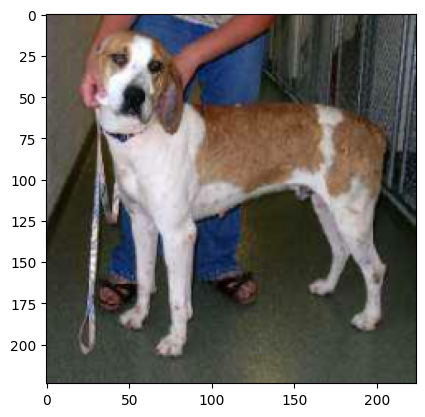

In [716]:
# Example usage
val_index = 10
val_images, val_labels = unbatch(val_data)
print(val_images[val_index],val_labels[val_index])
plt.imshow(val_images[val_index])

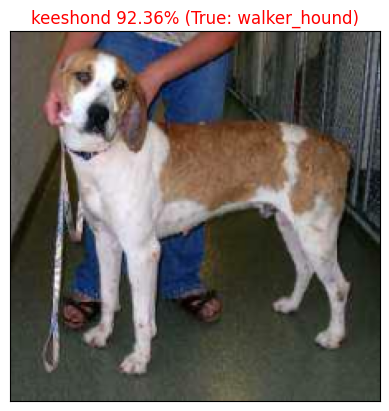

In [718]:
# Plotting prediction with image
def plot_pred(prediction_probabilities, labels, images, n=0):
    """Plots the image with its predicted and true label."""
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
    pred_label = get_pred_label(pred_prob)

    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    # Red for wrong and green for correct prediction
    color = "green" if pred_label == true_label else "red"
    plt.title(f"{pred_label} {np.max(pred_prob)*100:.2f}% (True: {true_label})", color=color)

# Example usage
plot_pred(prediction_probabilities=prediction, labels=val_labels, images=val_images, n=10)

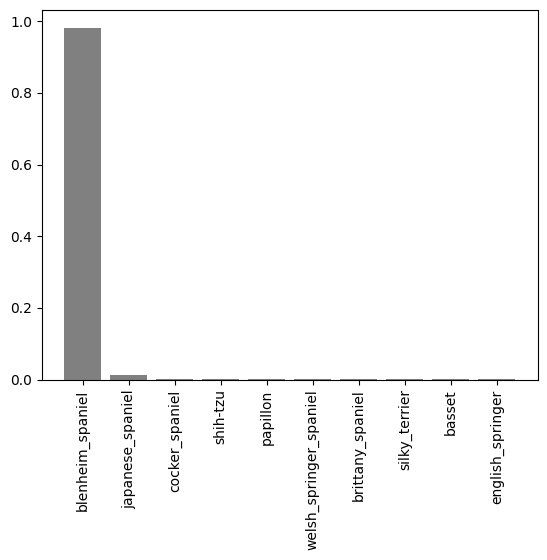

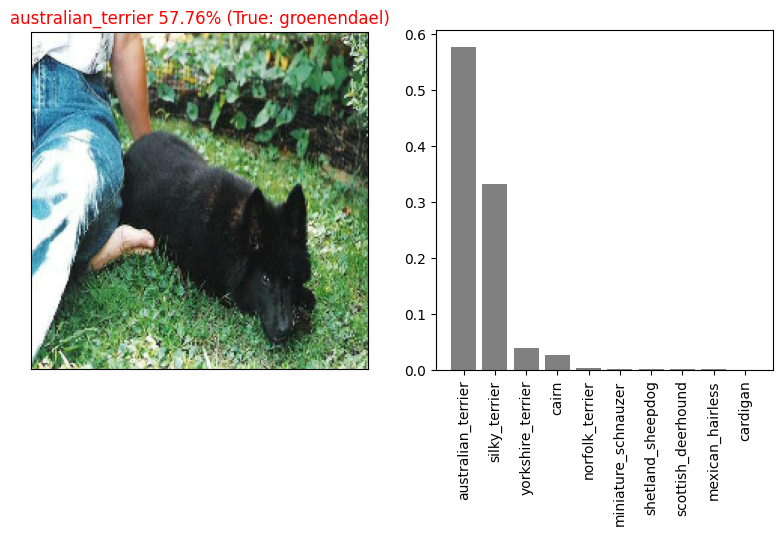

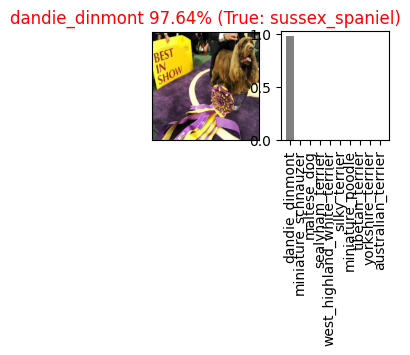

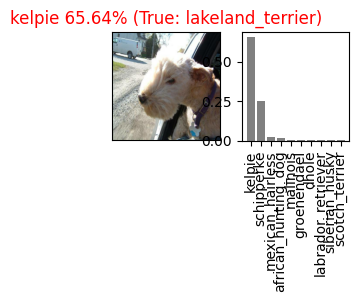

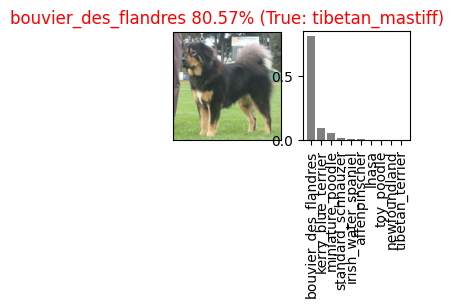

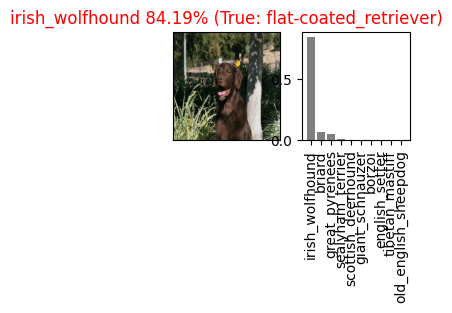

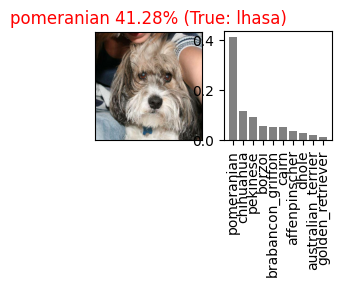

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plotting prediction confidence
def plot_pred_conf(prediction_probabilities, labels, unique_breeds, n=1):
    """Plots the top 10 prediction confidences for a given image."""
    pred_prob = prediction_probabilities[n]
    true_label = labels[n]
    pred_label = get_pred_label(pred_prob)

    # Get top 10 prediction confidence indices and values
    top_10_pred = pred_prob.argsort()[-10:][::-1]
    top_10_value = pred_prob[top_10_pred]
    top_10_label = unique_breeds[top_10_pred]

    # Plotting
    top_plot = plt.bar(np.arange(len(top_10_label)), top_10_value, color='grey')
    plt.xticks(np.arange(len(top_10_label)), labels=top_10_label, rotation='vertical')

    # Coloring
    if true_label in top_10_label:
        top_plot[np.argmax(top_10_label == true_label)].set_color('green')

    plt.show()

# Example usage
plot_pred_conf(prediction_probabilities=prediction, labels=val_labels, unique_breeds=unique_breeds, n=14)

# Visualizing multiple predictions and confidences
i_multiplier = 30
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))

for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_pred(prediction_probabilities=prediction, labels=val_labels, images=val_images, n=i+i_multiplier)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_pred_conf(prediction_probabilities=prediction, labels=val_labels, unique_breeds=unique_breeds, n=i+i_multiplier)

plt.tight_layout(h_pad=1.0)
plt.show()

##  Save and Load the Trained Model

In [ ]:
#create a function to save our model
def save_model(model, suffix=None):
  #model dir
  model_dir = f"{folderlocation}models/"
  model_path = model_dir + "-" + suffix + ".h5"
  model.save(model_path)
  return model_path

# saving our model
save_model(model, suffix = "1000_images_mobileNet_Adam")

C:\Users\joine\AppData\Roaming\Python\Python311\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'models/-1000_images_mobileNet_Adam.h5'

In [ ]:
#create a function to load a trained model
def load_model(model_path, modelname):
  print(f"Loading Saved Model: {model_path+  modelname }")
  model = keras.models.load_model(model_path + modelname, custom_objects = {"KerasLayer": hub.KerasLayer})
  return model

#loading trained model
loaded_model = load_model(folderlocation + "models/","-1000_images_mobileNet_Adam.h5")

Loading Saved Model: models/-1000_images_mobileNet_Adam.h5


### Evaluating the Trained Model

In [ ]:
#evaluating loaded model
loaded_model.evaluate(val_data)

7/7 [==============================] - 2s 224ms/step - loss: 1.2915 - accuracy: 0.6800


[1.2915143966674805, 0.6800000071525574]

# Training Full Model

1. Train, Save and Load the Full Model
2. Preparing the test data by converting it into data batches.
3. Making predictions on the test data and saving/loading the predictions.
4. Creating a pandas DataFrame to store the predictions and exporting it to CSV.
5. Making predictions on custom images.
6. Visualizing the predictions for custom images.

In [ ]:
train_data = create_data_batches(image_paths, bool_labels)

Creating training data batches...


In [ ]:
#create a model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4


In [ ]:
full_tensorboard_callback = create_tensorboard_callback()
full_model_early_stopping = keras.callbacks.EarlyStopping(monitor="accuracy", patience=3)

In [ ]:
full_model.fit(x=train_data, epochs = num_epocs, callbacks = [full_tensorboard_callback, full_model_early_stopping])

Epoch 1/5
320/320 [==============================] - 105s 267ms/step - loss: 1.2834 - accuracy: 0.6808
Epoch 2/5
320/320 [==============================] - 100s 290ms/step - loss: 0.3759 - accuracy: 0.8857
Epoch 3/5
320/320 [==============================] - 98s 289ms/step - loss: 0.2201 - accuracy: 0.9397
Epoch 4/5
320/320 [==============================] - 107s 277ms/step - loss: 0.1394 - accuracy: 0.9677
Epoch 5/5
320/320 [==============================] - 96s 281ms/step - loss: 0.0971 - accuracy: 0.9796


In [ ]:
#saving full model
save_model(full_model, suffix="full_image_reco_model")

## Load Full Model

In [408]:
# Load the full trained model
load_full = load_model(folderlocation + "models/","full_image_reco_model.h5")

TypeError: load_model() missing 1 required positional argument: 'modelname'

##  Prepare Test Data

In [ ]:
# Load test data
test_path = folderlocation + "test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
print(test_filenames[:12])
print(f"Number of test images: {len(test_filenames)}")

# Convert test data into data batches
test_data = create_data_batches(test_filenames, test_data=True)


## Make Predictions on Test Data

In [ ]:
# Make predictions on test data
test_predictions = load_full.predict(test_data, verbose=1)

# Save prediction data
np.savetxt(folderlocation + "pred_array_full.csv", test_predictions, delimiter=",")

# Load prediction data
test_predictions = np.loadtxt(folderlocation + "pred_array_full.csv", delimiter=",")
print(test_predictions[:10])

## Prepare Prediction Data

In [ ]:
# Steps to create a pandas DataFrame with ID and dog breed columns
columns = ["id"] + list(unique_breeds)
pred_df = pd.DataFrame(columns=columns)
print(pred_df.head())

# Append test image ID to prediction DataFrame
test_ids = [os.path.splitext(os.path.basename(path))[0] for path in test_filenames]
pred_df["id"] = test_ids
print(pred_df.head())

# Add prediction probability data
pred_df[list(unique_breeds)] = test_predictions
print(pred_df.head())

# Export prediction DataFrame to CSV
pred_df.to_csv(folderlocation + "full_model_prediction.csv", index=False)

## Make Predictions on Custom Images

In [ ]:
# Define custom image paths
custom_path = folderlocation + "custom_images/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]
print(custom_image_paths)

# Convert custom images into data batches
custom_data = create_data_batches(custom_image_paths, test_data=True)

# Make predictions on custom images
custom_predictions = load_full.predict(custom_data)
custom_pred_labels = [get_pred_label(custom_predictions[i]) for i in range(len(custom_predictions))]
print(custom_pred_labels)

## Visualize Custom Image Predictions

In [ ]:
# Function to plot custom image predictions
custom_images = []
for image in custom_data.unbatch().as_numpy_iterator():
    custom_images.append(image)

plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
    plt.subplot(1, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.title(custom_pred_labels[i])
    plt.imshow(image)
plt.show()